In [21]:
import os 
import sys
sys.path.append(os.path.abspath('../'))
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import datetime
import re
import math
import utilities.helper_functions as hf
import config


In [22]:
# load data using pandas from csv files in Data_with mouse Id 
# Data_wite mouse Id is a folder in the same directory as this file
path = config.remote_trial_path
processed_data_path = config.successful_trial_path
files = os.listdir(path)
files = [path + '/' + file for file in files]
 
 # load a dict of files keyed with the file name
log_data = {file.split('/')[-1].split('.')[0]: pd.read_csv(file) for file in files}
# get array of file names 
file_names = list(log_data.keys())
file_names.sort()

mouse_name_list = ['M' + str(i) for i in range(1,9)]
mouse_break_times = dict(zip(mouse_name_list, np.empty((8, 2))))
successful_trials_by_day = dict()

PermissionError: [Errno 13] Permission denied

In [ ]:
M1_M2 = []
M3_M4 = []
M5_M6 = []
M7_M8 = []
for file in file_names:
    print(file)
    df = log_data[file]
    matches = [ re.match('(M)[1-8]_?[L | R]?_beambreak_time in s', name) for name in df.columns.to_list()]
    L, R = None, None
    for match in matches:
        if match is not None:
            if L is None:
                L = match.string
            else:
                R = match.string
    
    # get the time at the start of the trial
    start_time = hf.process_time_string(file.split('_')[0])
    # get the datetime of each cue
    cue_times = df['cue_time in s'].apply(lambda x : hf.process_time_string(x))
    # subtract the start time from each cue time
    time_since_start = cue_times.apply(lambda x : x - start_time)
    # Get the names of each mouse
    mouse_name_L = L.split('_')[0]
    mouse_name_R = R.split('_')[0]
    # subtract the 2nd collumn from the 4th abd 7th collumns
    mouse_L_break_time = df.apply(lambda x : hf.subtract_time_series(x, 'cue_time in s', L), axis=1)
    mouse_R_break_time = df.apply(lambda x : hf.subtract_time_series(x, 'cue_time in s', R), axis=1)

    # run through both to see when both broke the beam, then record as a success for the day
    sucessful_trials = []
    # absolute difference between mouse L and mouse R break times
    time_between_breaks = []
    try:
        for i in range(len(mouse_L_break_time)):
            if not math.isnan(mouse_L_break_time[i]) and not math.isnan(mouse_R_break_time[i]) :
                sucessful_trials.append(True)
                time_between_breaks.append(abs(mouse_L_break_time[i] - mouse_R_break_time[i]))
            else:
                sucessful_trials.append(False)
                time_between_breaks.append(None)
    except:
        continue
    successful_trials_by_day[file] = {
        'names' : mouse_name_L + mouse_name_R,
        'L': mouse_L_break_time,
        'R': mouse_R_break_time,
        'successful_trials': sucessful_trials,
        'time_between_breaks': time_between_breaks,
        'time_since_start': time_since_start,
        'cue_times': cue_times}
    if mouse_name_L == 'M1' or mouse_name_L == 'M2':
        M1_M2.append(file)
    elif mouse_name_L == 'M3' or mouse_name_L == 'M4':
        M3_M4.append(file)
    elif mouse_name_L == 'M5' or mouse_name_L == 'M6':
        M5_M6.append(file)
    elif mouse_name_L == 'M7' or mouse_name_L == 'M8':
        M7_M8.append(file)
    # convert successful trials by day to a dataframe
    successful_trials_df = pd.DataFrame(successful_trials_by_day[file])
    # save the dataframe to a csv file
    successful_trials_df.to_csv(processed_data_path + file + '.csv')
    mouse_break_times[mouse_name_L] = np.concatenate((mouse_break_times[mouse_name_L], ( mouse_L_break_time.array)))
    mouse_break_times[mouse_name_R] = np.concatenate((mouse_break_times[mouse_name_R], ( mouse_R_break_time.array)))
# add all the mouse pairs to a dict
mouse_pairs = {
    'M1_M2': M1_M2,
    'M3_M4': M3_M4,
    'M5_M6': M5_M6,
    'M7_M8': M7_M8
}

20230712151237_log
20230712153221_log
20230712161638_log
20230713094734_log
20230713112212_log
20230714114827_log
20230714141658_log
20230714161545_log
20230718144045_log
20230718151456_log
20230718154037_log
20230718161229_log
20230719100754_log
20230719133329_log
20230719161841_log
20230720104701_log
20230720141801_log
20230720160110_log
20230721100255_log
20230721122412_log
20230721145114_log
20230721161826_log
20230725135856_log
20230725140516_log
20230810161151_log
20230810171031_log
20230812144422_log
20230812150714_log
20230812170534_log
20230812173242_log
20230814101104_log
20230814102821_log
20230814105352_log
20230814110033_log
20230814110818_log
20230814112206_log
20230814144753_log
20230814145140_log
20230814151140_log
20230814151714_log
20230814152150_log
20230814153947_log
20230814161151_log
20230815104201_log
20230815110109_log
20230815110825_log
20230815163010_log
20230816103729_log
20230817105415_log
20230818120023_log
20230818121524_log
20230818140009_log
202308221328

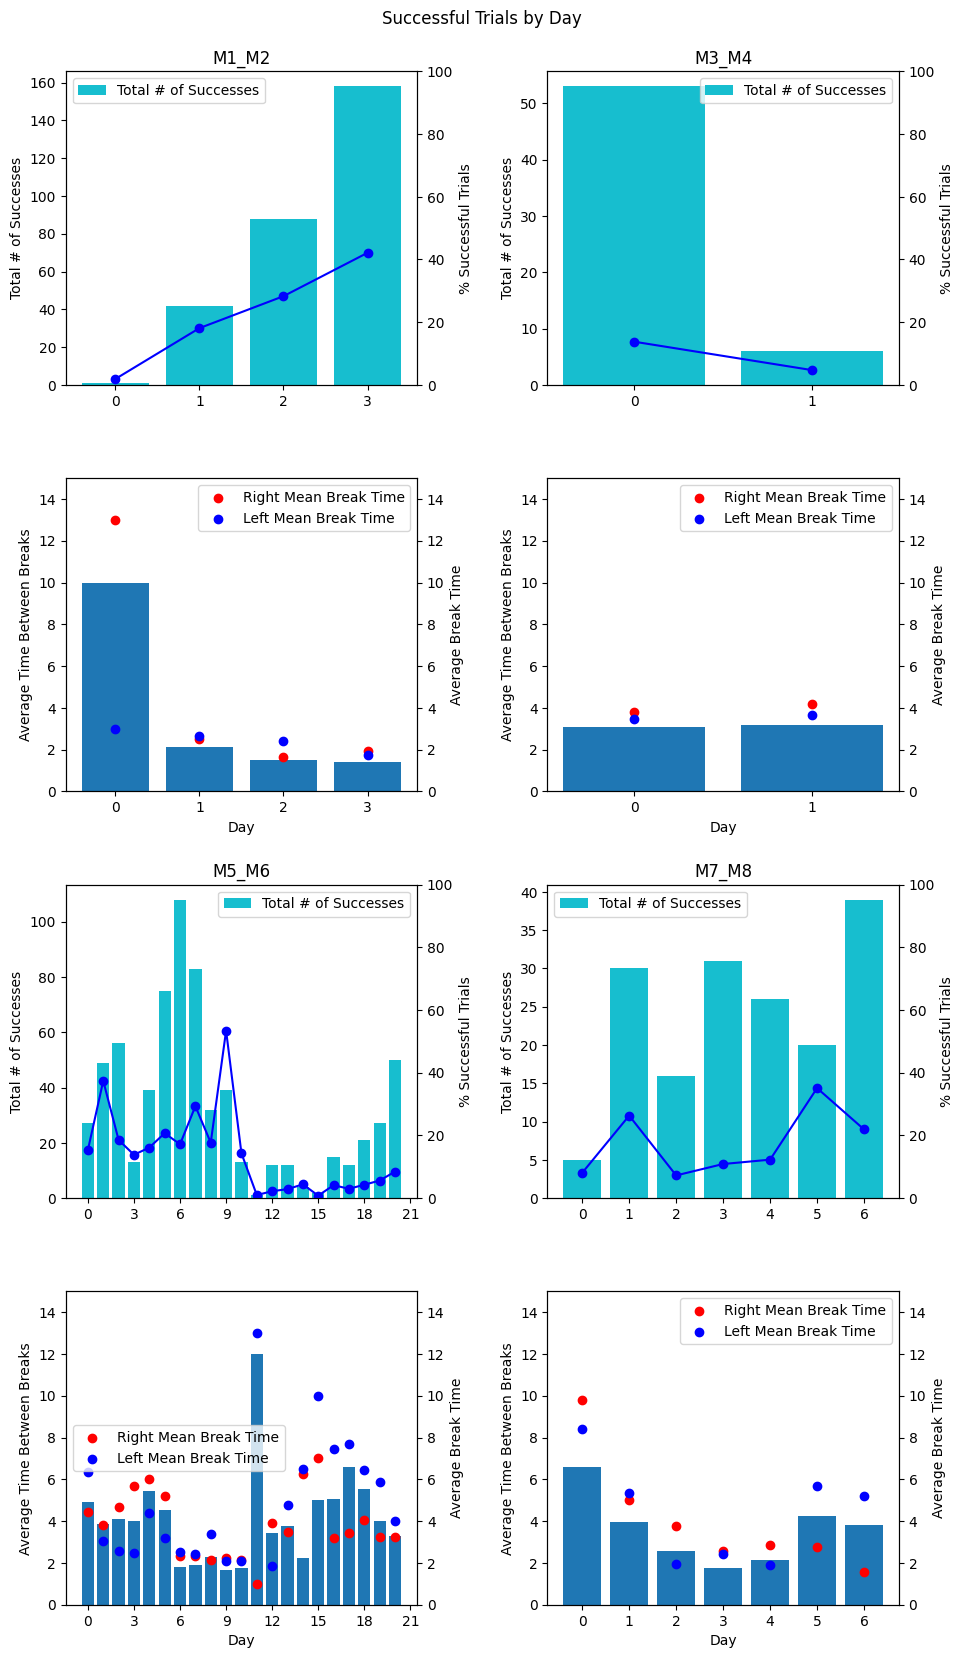

In [ ]:
# iterate through all mouse pairs and plot # successes
# create 8 subplots
fig, axs = plt.subplots(4, 2)
fig.suptitle('Successful Trials by Day')
# enlarge figure
fig.set_size_inches(10, 17)
# iterate through mouse pairs
for i, pair in enumerate(mouse_pairs):
    trials_success_rate = []
    average_time_between_breaks = []
    L_mean_break_times = []
    R_mean_break_times = []
    successes_per_day = []
    for file in mouse_pairs[pair]:
        # only take files with more than 10 entries
        if len(successful_trials_by_day[file]['successful_trials']) > 50 and (sum(successful_trials_by_day[file]['successful_trials'])) > 0:
            trials_success_rate.append(sum(successful_trials_by_day[file]['successful_trials']) / len(successful_trials_by_day[file]['successful_trials']))
            time_between_breaks = [x for x in successful_trials_by_day[file]['time_between_breaks'] if x is not None]
            # mask L and R break times to only include successful trials
            L_break_times = np.ma.masked_array(successful_trials_by_day[file]['L'], np.logical_not(successful_trials_by_day[file]['successful_trials']))
            R_break_times = np.ma.masked_array(successful_trials_by_day[file]['R'], np.logical_not(successful_trials_by_day[file]['successful_trials']))
            R_mean_break_times.append(np.mean(R_break_times))
            L_mean_break_times.append(np.mean(L_break_times))
            successes_per_day.append(sum(successful_trials_by_day[file]['successful_trials']))
            if len(time_between_breaks) > 0:
                average_time_between_breaks.append(np.mean(time_between_breaks))
            else:
                average_time_between_breaks.append(None)
    # generate a twin plot and plot total # of successes
    twin_axs = axs[(i//2) * 2, i%2].twinx()
    # plot the Success rate for each day
    twin_axs.plot(range(len(trials_success_rate)), np.array(trials_success_rate) * 100, color='blue', label='Success Rate', marker='o')
    twin_axs.set_title(pair)
    twin_axs.set_xlabel('Day')
    twin_axs.set_ylabel('% Successful Trials')
    # set y range to include 0 and 1
    twin_axs.set_ylim([0, 100])
    # make x ticks integers
    twin_axs.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    axs[(i//2) * 2, i%2].bar(range(len(trials_success_rate)), successes_per_day, color='tab:cyan', label='Total # of Successes')
    # move to back layer
    axs[(i//2) * 2, i%2].set_zorder(0)
    axs[(i//2) * 2, i%2].set_ylabel('Total # of Successes')
    axs[(i//2) * 2, i%2].legend()
    # plot the average time between breaks for each day
    axs[(i//2) * 2 + 1, i%2].bar(range(len(trials_success_rate)), average_time_between_breaks)
    axs[(i//2) * 2 + 1, i%2].set_xlabel('Day')
    axs[(i//2) * 2 + 1, i%2].set_ylabel('Average Time Between Breaks')    # make x ticks integers
    axs[(i//2) * 2 + 1, i%2].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    R_L_mean_ax = axs[(i//2) * 2 + 1, i%2].twinx()
    R_L_mean_ax.scatter(range(len(trials_success_rate)), R_mean_break_times, color='red', label='Right Mean Break Time')
    R_L_mean_ax.scatter(range(len(trials_success_rate)), L_mean_break_times, color='blue', label='Left Mean Break Time')
    R_L_mean_ax.set_ylabel('Average Break Time')
    R_L_mean_ax.legend()
    # set y lim between 0 and 15
    axs[(i//2) * 2 + 1, i%2].set_ylim([0, 15])
    R_L_mean_ax.set_ylim([0, 15])
   
# space the plots so titles dont overlap
fig.tight_layout(pad=2.0)
plt.show()
# export as svg
fig.savefig(config.media_path + 'successful_trials_by_day.svg', format='svg', dpi=1200)

In [ ]:
# for each mose in mouse_break_times, plot a scatter plot of the break times
clean_mouse_break_times = dict()
for mouse in mouse_break_times:
    # remove all nan values
    clean_mouse_data = mouse_break_times[mouse][~np.isnan(mouse_break_times[mouse])]
    # remove first two values
    clean_mouse_data = clean_mouse_data[2:]
    # remove outlier values greater than 60
    clean_mouse_data = clean_mouse_data[clean_mouse_data < 60]
    clean_mouse_break_times[mouse] = clean_mouse_data


/tmp/ipykernel_635363/1854328430.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  clean_mouse_break_times = {key: value for key, value in clean_mouse_break_times.items() if value != []}


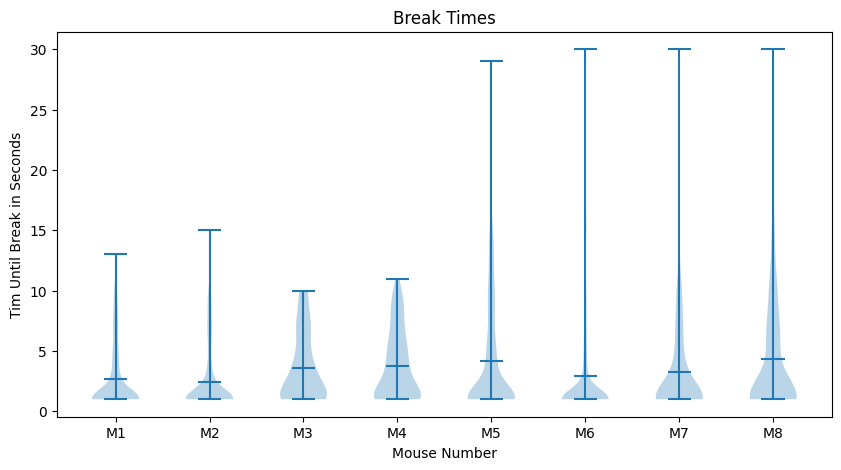

In [ ]:
# violin plot of break times per mouse
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
# filter none values from dict
clean_mouse_break_times = {key: value for key, value in clean_mouse_break_times.items() if value != []}
mouse_break_array = (list(clean_mouse_break_times.values()))
axs.violinplot(mouse_break_array[0:8], showmeans=True)
axs.set_title('Break Times')
axs.set_xlabel('Mouse Number')
axs.set_ylabel('Tim Until Break in Seconds')
axs.set_xticks(range(1,9))
axs.set_xticklabels(mouse_name_list)
plt.show()
fig.savefig(config.media_path + 'violinplot.svg', format='svg', dpi=1200)

{'M1': [0],
 'M2': [0],
 'M3': [0],
 'M4': [0],
 'M5': [0],
 'M6': [0],
 'M7': [0],
 'M8': [0]}

error
20230814153947_log
[None, None, None, <re.Match object; span=(0, 22), match='M8_beambreak_time in s'>, None, None, <re.Match object; span=(0, 22), match='M6_beambreak_time in s'>, None, None, None, None, None, None, None]
error
20230814161151_log
[None, None, None, <re.Match object; span=(0, 22), match='M8_beambreak_time in s'>, None, None, <re.Match object; span=(0, 22), match='M6_beambreak_time in s'>, None, None, None, None, None, None, None]


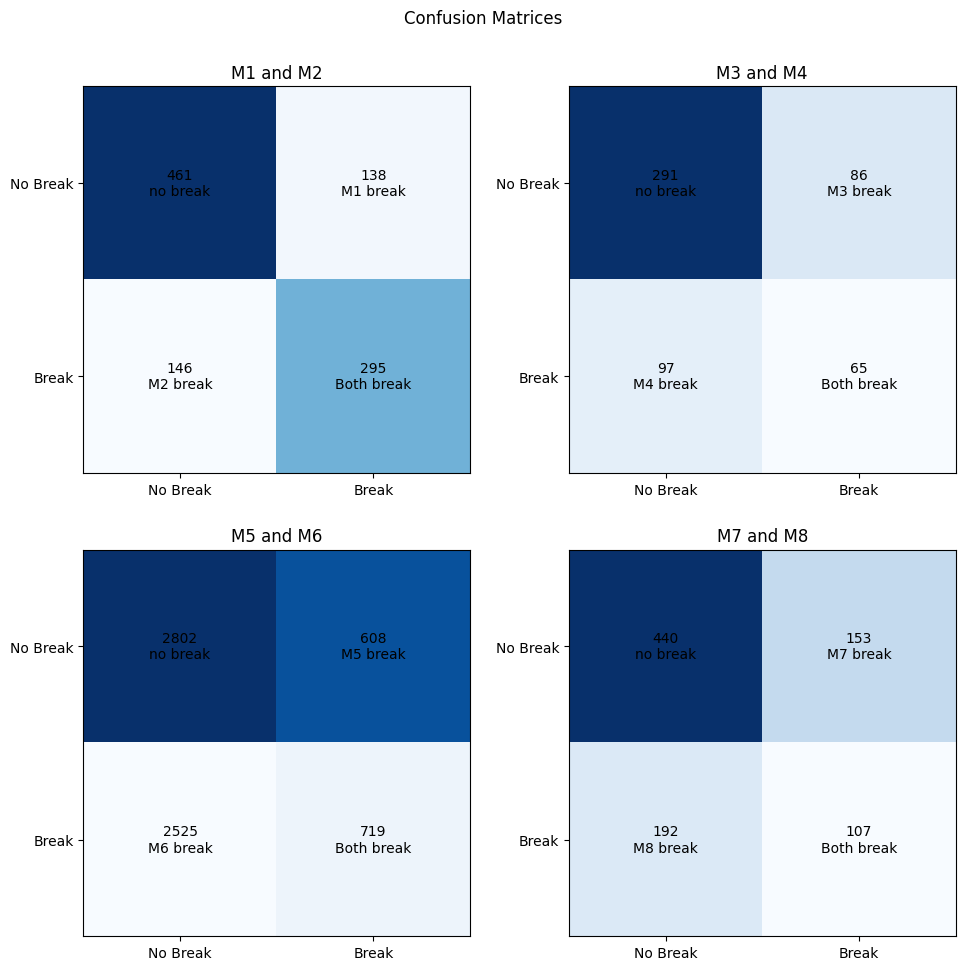

In [28]:
# create a confusion matrix of whether L or R break 
from sklearn.metrics import confusion_matrix
# create dict of all mice break times
mouse_break_times = dict(zip(mouse_name_list, [[0] for i in range(8)]))
display(mouse_break_times)
for file in file_names:
    df = log_data[file]
    # get mice names
    matches = [ re.match('(M)[1-8](_[L | R])?_beambreak_time in s', name) for name in df.columns.to_list()]
    L = None
    R = None
    for match in matches:
        if match is not None:
            if match.string.split('_')[1] == 'R' or int(match.string[1]) % 2 == 0:
                R = match.string
            else:
                L = match.string
    
    # extract all the m1 times and label whether they exist or are nan
    try:
        mouse_break_times[L[0:2]].extend(df[L].apply(lambda x : 0 if math.isnan(float(x)) else 1).tolist())
        mouse_break_times[R[0:2]].extend(df[R].apply(lambda x : 0 if math.isnan(float(x)) else 1).tolist())
    except:
        print('error')
        print(file)
        print(matches)
# remove first 2 entries from each list
for key in mouse_break_times.keys():
    mouse_break_times[key] = mouse_break_times[key][2:]
fig, axs = plt.subplots(2, 2)
fig.suptitle('Confusion Matrices')
fig.set_size_inches(10, 10)
for i in range(4):
    L  = (mouse_break_times[mouse_name_list[2 * i]])[1:]
    R = (mouse_break_times[mouse_name_list[2 * i + 1]])[1:]
    # create confusion matrix
    cm = confusion_matrix(L, R)
    # plot confusion matrix
    axs[i//2, i%2].imshow(cm, cmap=plt.cm.Blues)
    axs[i//2, i%2].set_title('M' + str(2 * i + 1) + ' and M' + str(2 * i + 2))
    # axs[i//2, i%2].set_xlabel('M' + str(2 * i + 2))
    # axs[i//2, i%2].set_ylabel('M' + str(2 * i + 1))
    axs[i//2, i%2].set_xticks([0, 1])
    axs[i//2, i%2].set_yticks([0, 1])
    axs[i//2, i%2].set_xticklabels(['No Break', 'Break'])
    axs[i//2, i%2].set_yticklabels(['No Break', 'Break'])
    # add text to each square
    thresh = cm.max() / 2.
    for j in range(2):
        for k in range(2):
            if j == 1 and k == 1:
                context_str = 'Both'
            elif j == 0 and k == 0:
                context_str = 'no'
            elif j == 1 and k == 0:
                context_str = mouse_name_list[2 * i]
            else:
                context_str = mouse_name_list[2 * i + 1]
            axs[i//2, i%2].text(j, k, format(cm[j, k], 'd') +'\n'+ context_str + ' break',
                    ha="center", va="center",
                    color="white" if cm[j, k] > thresh * 2 else "black")
fig.tight_layout(pad=2.0)
fig.savefig(config.media_path + 'confusionmat.svg', format='svg', dpi=1200)

(2, 1035)

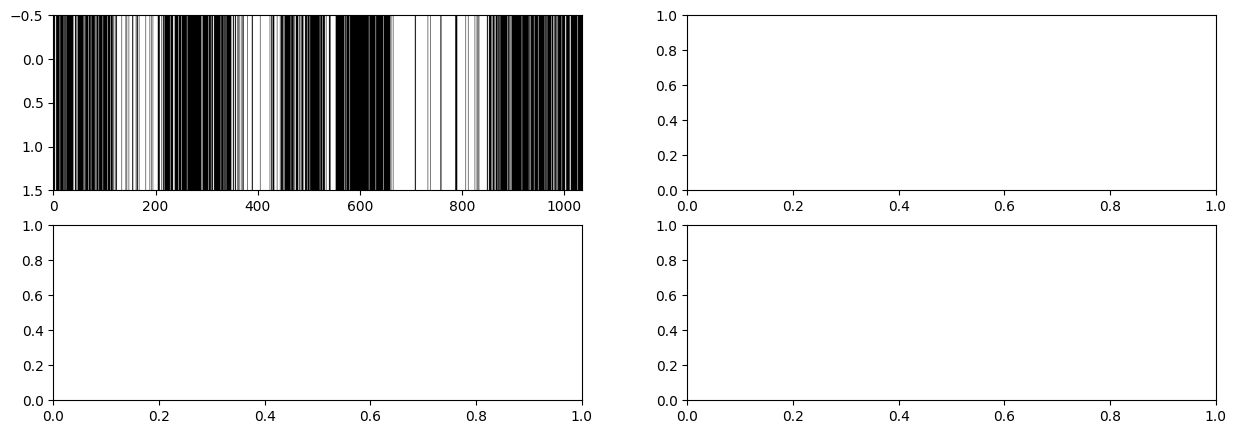

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
combined_times = np.array([mouse_break_times['M1'], mouse_break_times['M1']])
# reshape to only having 100 entries per row
display(combined_times.shape)
axs[0, 0].imshow(combined_times, cmap='gray', aspect='auto')

In [ ]:
# import for mpatches
import matplotlib.patches as mpatches
def plot_mouse_tasks(mouse1, mouse2):
    # Calculate the number of rows and columns based on the size of the input arrays
    nrows = math.ceil(np.sqrt(len(mouse1) ))
    ncols = math.ceil(len(mouse1)  / nrows)

    # Calculate the amount of padding needed to make the arrays evenly divided by rows and columns
    pad_elements = (nrows * ncols) - len(mouse1)

    # Pad the input arrays to ensure even division by rows and columns
    mouse1 = np.pad(mouse1, (0, pad_elements), 'constant', constant_values=0)
    mouse2 = np.pad(mouse2, (0, pad_elements), 'constant', constant_values=0)

    # Reshape 1D arrays into 2D arrays
    mouse1 = mouse1.reshape(nrows, ncols)
    mouse2 = mouse2.reshape(nrows, ncols)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 6))
    legend_labels = []
    for i in range(nrows):
        for j in range(ncols):
            if mouse1[i, j] == 1 and mouse2[i, j] == 1:
                ax[i, j].add_patch(plt.Rectangle((0, 0), 1, 1, fc='red', ec='black'))
                legend_labels.append('Both')
            elif mouse1[i, j] == 1:
                ax[i, j].add_patch(plt.Rectangle((0, 0), 1, 1, fc='green', ec='black'))
                legend_labels.append('Mouse 1')
            elif mouse2[i, j] == 1:
                ax[i, j].add_patch(plt.Rectangle((0, 0), 1, 1, fc='cyan', ec='black'))
                legend_labels.append('Mouse 2')
            else:
                ax[i, j].add_patch(plt.Rectangle((0, 0), 1, 1, fc='white', ec='black'))
                legend_labels.append('Neither')

            ax[i, j].set_xlim(0, 1)
            ax[i, j].set_ylim(0, 1)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    # Create a legend at the bottom
    plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, fc='red', ec='black'),
                        plt.Rectangle((0, 0), 1, 1, fc='white', ec='black'),
                        plt.Rectangle((0, 0), 1, 1, fc='green', ec='black'),
                        plt.Rectangle((0, 0), 1, 1, fc='cyan', ec='black'),],
               labels=legend_labels,
               loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5)

    

    return fig, ax

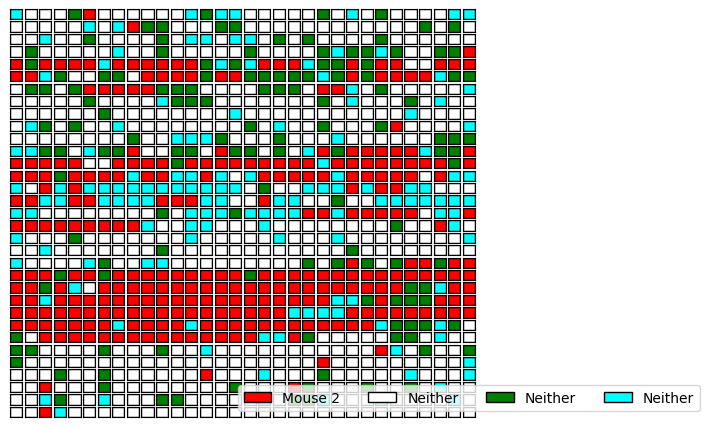

In [ ]:
fig, ax = plot_mouse_tasks(np.array(mouse_break_times['M1']), np.array(mouse_break_times['M2']))
# add padding to the bottom of the figure
fig.subplots_adjust(bottom=0.2)

plt.show()